In [2]:
!unzip consumer_complaints.csv.zip

Archive:  consumer_complaints.csv.zip
  inflating: Consumer_Complaints.csv  


In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score

import nltk
import string
import re

import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('Consumer_Complaints.csv')

In [7]:
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,03-12-2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,10-01-2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,06-08-2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [8]:
data = pd.DataFrame(df['Consumer Complaint'].to_list(),columns=['Text'])
data.count()

Text    277814
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data.count()

Text    277814
dtype: int64

In [11]:
data['Length'] = data.apply(lambda row: len(row['Text']),axis=1)
data.head()

,Text,Length
1,I have outdated information on my credit repor...,200
2,I purchased a new car on XXXX XXXX. The car de...,2042
7,An account on my credit report has a mistaken ...,1165
12,This company refuses to provide me verificatio...,136
16,This complaint is in regards to Square Two Fin...,1796


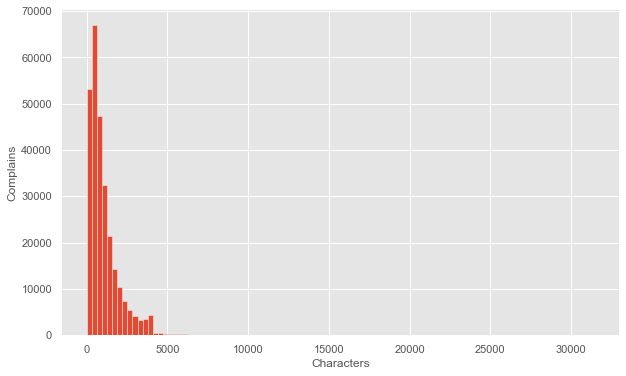

In [29]:
import seaborn as sns
sns.set()
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.hist(data['Length'],bins=100)
plt.xlabel("Characters")
plt.ylabel("Complains")
plt.show()

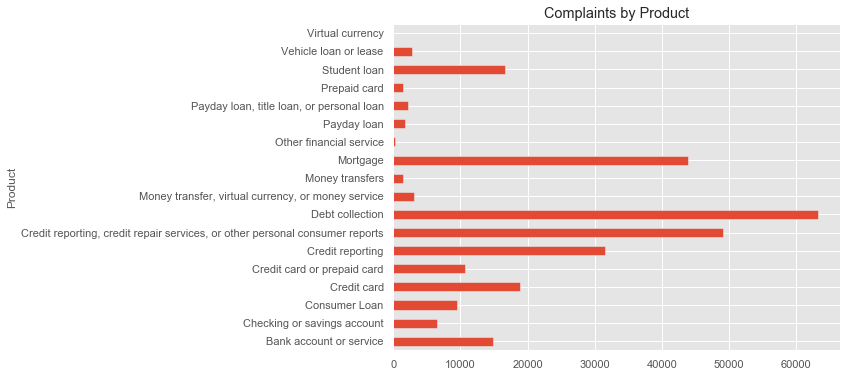

In [17]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer Complaint'].count().plot.barh(ylim=0)
plt.title('Complaints by Product')
plt.show()

In [18]:
df.shape

(1025010, 19)

In [19]:
drop_indices = np.random.choice(df.index, 1000000, replace=False)
df = df.drop(drop_indices)
df.shape

(25010, 19)

In [20]:
df = df[['Product', 'Consumer Complaint']]
df = df[pd.notnull(df['Consumer Complaint'])]
df['Complaint Category'] = df['Product'].factorize()[0]

df.head()

,Product,Consumer Complaint,Complaint Category
237,Credit reporting,I had received several letters from XXXX XXXX ...,0
262,Mortgage,My present mortgage has been identified as one...,1
287,Credit card,Hello Dear CFPB I want to share my experience ...,2
715,Bank account or service,I have opened the account of Bank of America a...,3
893,Consumer Loan,"I leased a vehicle from XXXX XXXX of XXXX, CT ...",4


In [21]:
complaint_category_df = df[['Product', 'Complaint Category']].drop_duplicates().sort_values('Complaint Category')

# Dictionary for category -> id
complaint_category_ids = dict(complaint_category_df.values)

# Dictionary for id -> category
complaint_categories = dict(complaint_category_df[['Complaint Category', 'Product']].values)

complaint_category_df

,Product,Complaint Category
237,Credit reporting,0
262,Mortgage,1
287,Credit card,2
715,Bank account or service,3
893,Consumer Loan,4
947,Debt collection,5
5292,"Money transfer, virtual currency, or money ser...",6
7220,Student loan,7
8508,"Credit reporting, credit repair services, or o...",8
11248,Prepaid card,9


In [23]:
import nltk
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer() 
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def sentence_clean(sentence):
  sentence = re.sub('[^a-z\s]', '', sentence.lower())
  word_list = tokenizer.tokenize(sentence)
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  return lemmatized_output

df['Consumer Complaint'] = df['Consumer Complaint'].apply(sentence_clean)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saketlakhotia/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Product,Consumer Complaint,Complaint Category
237,Credit reporting,i had received several letter from xxxx xxxx x...,0
262,Mortgage,my present mortgage ha been identified a one o...,1
287,Credit card,hello dear cfpb i want to share my experience ...,2
715,Bank account or service,i have opened the account of bank of america a...,3
893,Consumer Loan,i leased a vehicle from xxxx xxxx of xxxx ct i...,4


In [24]:
tf_idf_vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
tf_idf = tf_idf_vectorizer.fit_transform(df['Consumer Complaint'])
tf_idf_normalised = normalize(tf_idf)
features = tf_idf_normalised.toarray()

pd.DataFrame(features, columns=tf_idf_vectorizer.get_feature_names()).head()

,aa,aaa,aadvantage,aafes,aan,aargon,aastra,ab,aba,abandon,...,zeroed,zeropercent,zevie,zip,zipped,zombie,zone,zoned,zonethanking,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


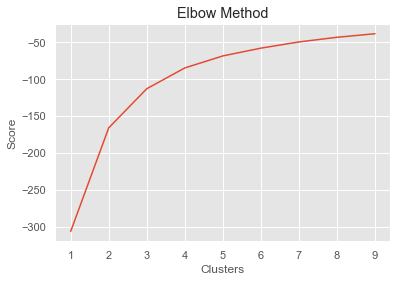

In [30]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features)

number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]

plt.plot(number_clusters, score)
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

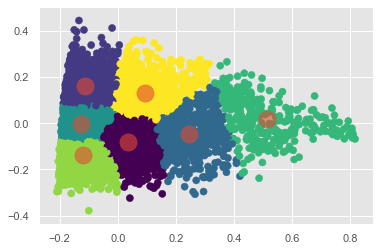

In [26]:
kmeans = KMeans(n_clusters=7, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, alpha=0.6)

In [27]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)
        x_means = np.mean(tf_idf_array[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(features, prediction, 15)

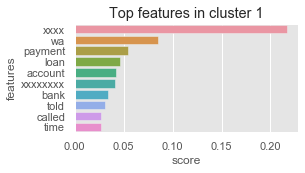

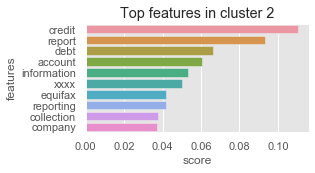

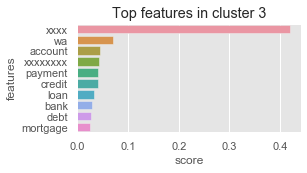

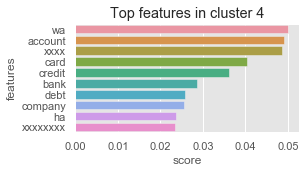

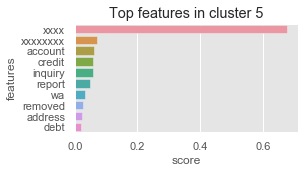

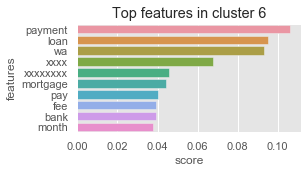

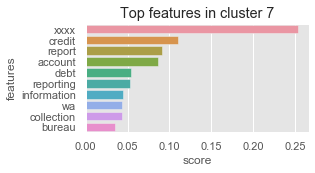

In [28]:
import seaborn as sns

for i in range(7):
  plt.figure(figsize=(4,2))
  sns.barplot(x = 'score', y = 'features', orient = 'h', data = dfs[i][:10])
  plt.title('Top features in cluster {}'.format(i+1))
  plt.show()